# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

from Data.load_data import get_energy_data
from helper_functions import create_error_metrics

Importing plotly failed. Interactive plots will not work.


## Model Selection

### Prophet
> Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

> Prophet is open source software released by Facebook's Core Data Science team. It is available for download on CRAN and PyPI.

https://facebook.github.io/prophet/

A model description can be found in this [paper](https://peerj.com/preprints/3190/).

Our data consists of different types of seasonality (seasons, weekend/working day and day/night) such that it should work very well with prophet.

Assumptions:
- We assume that seasonality is additive, i.e. seasonality does not grow with the trend: [docs multiplicative_seasonality](https://facebook.github.io/prophet/docs/multiplicative_seasonality.html)
- We start with Prophet's default fitting of saisonalities (yearly, weekly, daily): [docs custom seasonalities](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#specifying-custom-seasonalities)
- We use the default holidays for Germany from Prophet
- We ignore temperature in the first step as adding an additional regressor to the prophet model requires the regressor to be known in the past and also the future. This means this data comes from another source (could also be predicted values from another model): [docs additional regressors](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#additional-regressors)


## Load data


In [3]:
# Load the dataset
df = get_energy_data()

df_prophet = pd.DataFrame()
df_prophet['ds'] = list(map(lambda x: x.replace(tzinfo=None), df.index))
df_prophet['y'] = df['Load'].reset_index(inplace=False)['Load']

# Split the dataset
df_train_prophet, df_test_prophet = train_test_split(df_prophet, test_size=0.2, shuffle=False)


## Hyperparameter Tuning

The hyperparameter tuning is done by varying the changepoint_prior_scale as well as the seasonality_prior_scale.

The changepoint_prior_scale determines the trend flexibility. The default value is 0.05. The documentation recommends to use a range of 0.001 to 0.5 [source](https://facebook.github.io/prophet/docs/diagnostics.html)

The seasonality_prior_scale determines the flexibility of the seasonality. The default value is 10 which means there is no regularization. A recommended range of values is between 0.01 and 10.

In [4]:
changepoint_prior_scale = [0.001, 0.01, 0.1, 0.5]
seasonality_prior_scale = [0.01, 0.1, 1.0, 10.0]

df_errors = pd.DataFrame({'changepoint': [], 'seasonality': [], 'MAE': [], 'MSE': [], 'RMSE': [], 'MAPE %': [], 'R2 %': []})

for changepoint in changepoint_prior_scale:
    for seasonality in seasonality_prior_scale:
        m = Prophet(
            changepoint_prior_scale=changepoint,
            seasonality_prior_scale=seasonality
        ).fit(df_train_prophet)
        
        future = m.make_future_dataframe(periods=df_test_prophet.shape[0], freq='H')
        forecast = m.predict(future)

        errors = create_error_metrics(df_test_prophet['y'], forecast['yhat'].iloc[df_train_prophet.shape[0]:])
        errors['changepoint'] = [changepoint]
        errors['seasonality'] = [seasonality]
        
        df_errors = pd.concat([df_errors, errors])
        
print(df_errors)

19:41:16 - cmdstanpy - INFO - Chain [1] start processing
19:41:17 - cmdstanpy - INFO - Chain [1] done processing
19:41:22 - cmdstanpy - INFO - Chain [1] start processing
19:41:24 - cmdstanpy - INFO - Chain [1] done processing
19:41:29 - cmdstanpy - INFO - Chain [1] start processing
19:41:31 - cmdstanpy - INFO - Chain [1] done processing
19:41:37 - cmdstanpy - INFO - Chain [1] start processing
19:41:38 - cmdstanpy - INFO - Chain [1] done processing
19:41:44 - cmdstanpy - INFO - Chain [1] start processing
19:41:48 - cmdstanpy - INFO - Chain [1] done processing
19:41:53 - cmdstanpy - INFO - Chain [1] start processing
19:41:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:03 - cmdstanpy - INFO - Chain [1] start processing
19:42:06 - cmdstanpy - INFO - Chain [1] done processing
19:42:12 - cmdstanpy - INFO - Chain [1] start processing
19:42:16 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing
19:42:34 - cmdstanpy - INFO - Chain [1]

   changepoint  seasonality       MAE           MSE      RMSE  MAPE %    R2 %
0        0.001         0.01  11771.12  2.536920e+08  15927.71    5.61   83.24
0        0.001         0.10  11762.29  2.537784e+08  15930.42    5.60   83.24
0        0.001         1.00  11755.71  2.540448e+08  15938.78    5.61   83.22
0        0.001        10.00  11766.49  2.536778e+08  15927.26    5.60   83.25
0        0.010         0.01  11933.57  2.642738e+08  16256.50    5.77   82.55
0        0.010         0.10  12007.82  2.682922e+08  16379.63    5.82   82.28
0        0.010         1.00  11900.44  2.634527e+08  16231.23    5.75   82.60
0        0.010        10.00  11970.10  2.663923e+08  16321.53    5.80   82.41
0        0.100         0.01  21337.92  6.687131e+08  25859.49   10.29   55.83
0        0.100         0.10  36764.69  1.749369e+09  41825.46   17.29  -15.54
0        0.100         1.00  33334.87  1.469090e+09  38328.71   15.72    2.97
0        0.100        10.00  33687.21  1.495895e+09  38676.81   

## Implementation


In [5]:
# Add additional holidays
# Fronleichnam: 15.06.2017, 31.05.2018, 20.6.2019
# Allerheiligen: 01.11.XXXX
additional_holidays_no_window = pd.DataFrame({
    'holiday': 'additional_german_holidays',
    'ds': pd.to_datetime([
        '2017-12-31', '2018-12-31', '2019-12-31',
        '2017-11-01', '2018-11-01', '2019-11-01',
        '2017-06-15', '2018-05-31', '2019-06-20',
    ]),
    'lower_window': 0,
    'upper_window': 0,
})

# Make week between Christmas and new year a special week
additional_holidays_upper_window = pd.DataFrame({
    'holiday': 'additional_german_holidays',
    'ds': pd.to_datetime([
        '2017-12-24', '2018-12-24', '2019-12-24',
    ]),
    'lower_window': -1,
    'upper_window': 7,
})

holidays = pd.concat([additional_holidays_no_window, additional_holidays_upper_window])

prophet2 = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=0.1, holidays=holidays,
                   scaling='minmax')  # making the trend less flexible or flat with growth='flat'
prophet2.add_country_holidays(country_name='DE')
prophet2.fit(df_train_prophet)
future2 = prophet2.make_future_dataframe(periods=df_test_prophet.shape[0], freq='H')
forecast2 = prophet2.predict(future2)


19:44:41 - cmdstanpy - INFO - Chain [1] start processing
19:44:43 - cmdstanpy - INFO - Chain [1] done processing


## Graphics

C:\Users\kai_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\kai_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


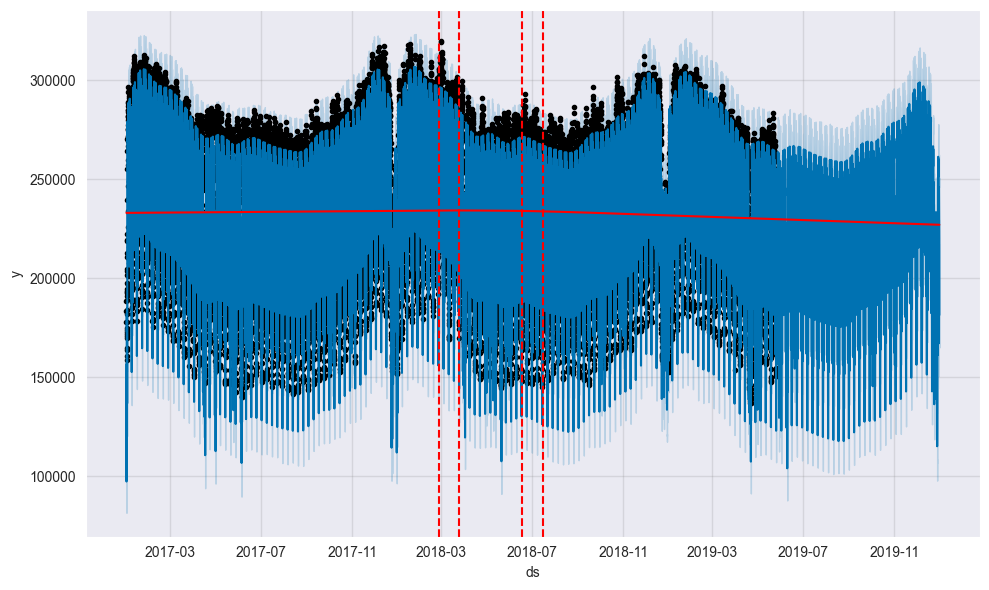

In [6]:
fig1 = prophet2.plot(forecast2)
a = add_changepoints_to_plot(fig1.gca(), prophet2, forecast2)

C:\Users\kai_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\kai_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\kai_p\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

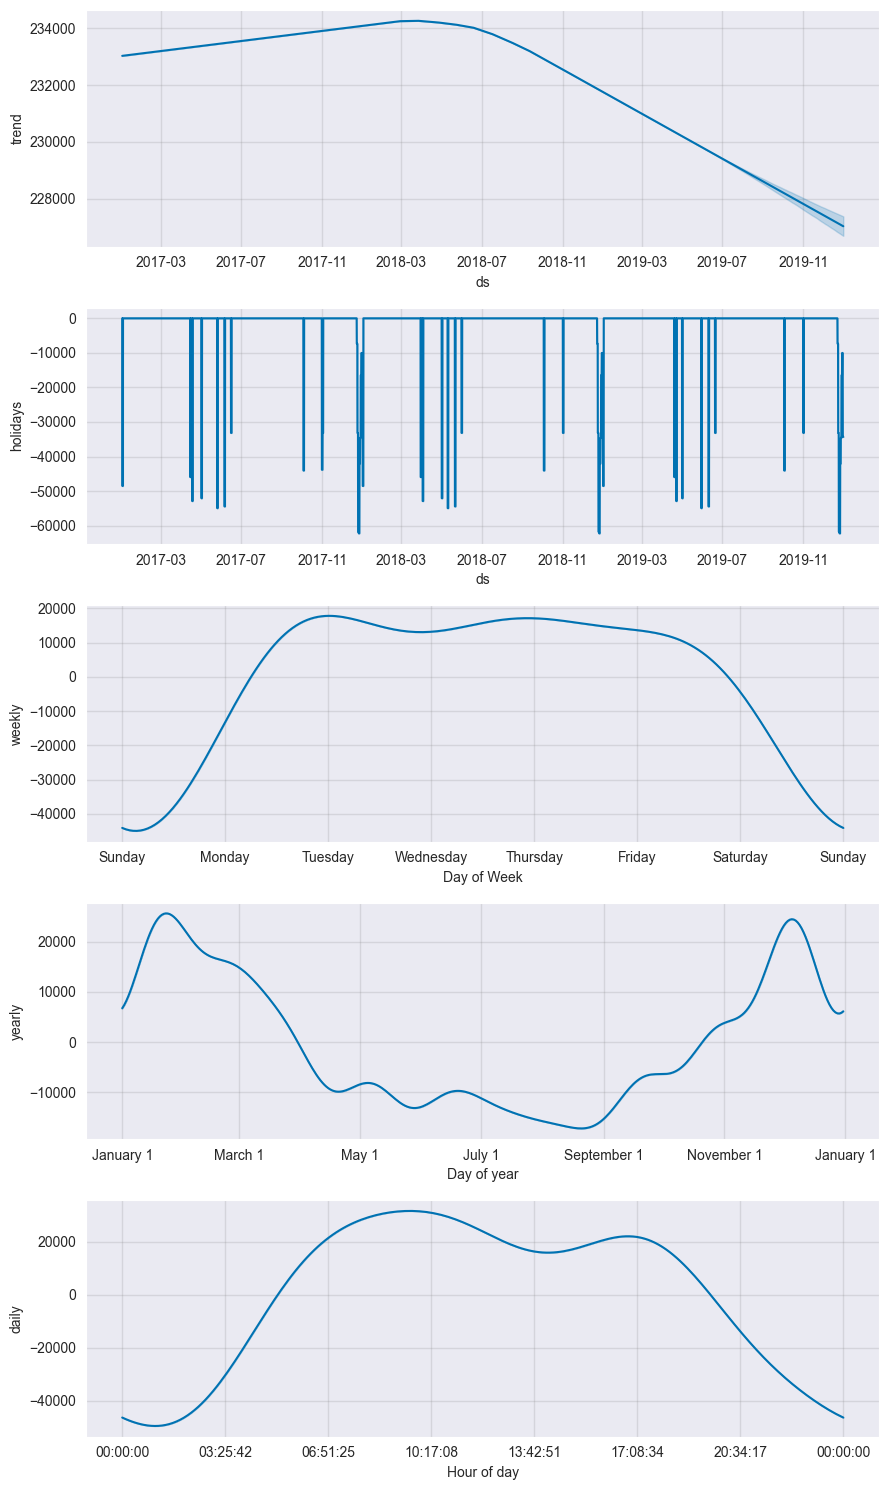

In [7]:
fig2 = prophet2.plot_components(forecast2)

<Axes: xlabel='ds'>

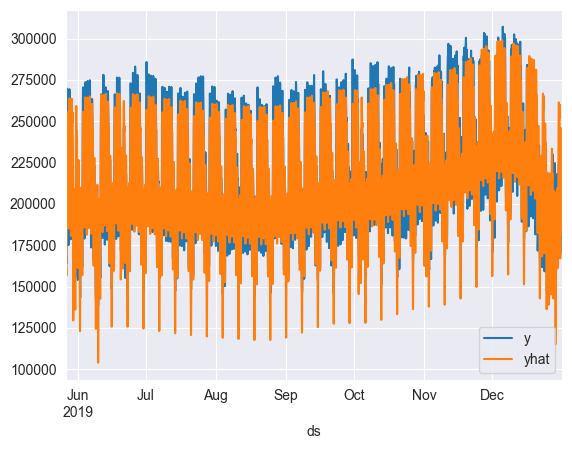

In [8]:
df_pred_prophet2 = pd.DataFrame()
df_pred_prophet2['y'] = df_test_prophet['y']
df_pred_prophet2['yhat'] = forecast2['yhat'].iloc[int(df_train_prophet.shape[0]):]
df_pred_prophet2.index = df_test_prophet['ds']
df_pred_prophet2[['y', 'yhat']].plot()

<Axes: xlabel='ds'>

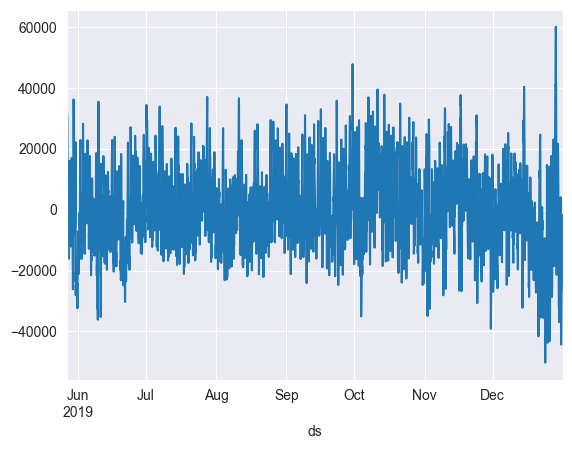

In [9]:
df_pred_prophet2['residuals'] = df_pred_prophet2['y'] - df_pred_prophet2['yhat']
df_pred_prophet2['residuals'].plot()

<Axes: >

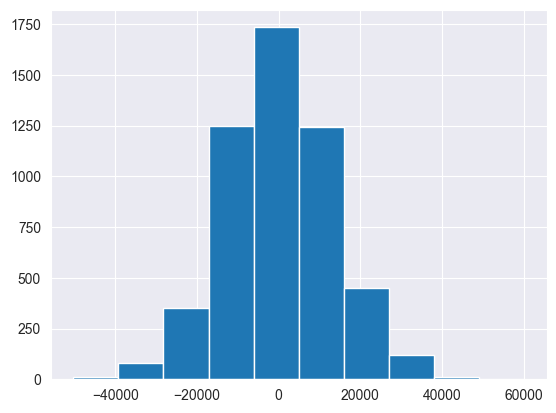

In [10]:
df_pred_prophet2['residuals'].hist()

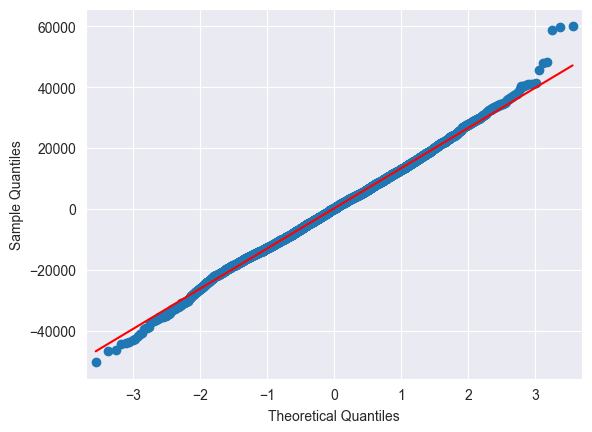

In [11]:
sm.qqplot(df_pred_prophet2['residuals'], line='s')
plt.show()

In [12]:
df_pred_prophet2['residuals']

ds
2019-05-26 23:00:00     5745.499322
2019-05-27 00:00:00     6609.631862
2019-05-27 01:00:00     7143.671826
2019-05-27 02:00:00     8134.404305
2019-05-27 03:00:00    10690.078438
                           ...     
2019-12-31 18:00:00   -22038.629200
2019-12-31 19:00:00   -23898.502112
2019-12-31 20:00:00   -17274.224298
2019-12-31 21:00:00    -5442.990054
2019-12-31 22:00:00    -1753.885950
Name: residuals, Length: 5256, dtype: float64

## Evaluation Metrics

In [13]:
create_error_metrics(df_test_prophet['y'], forecast2['yhat'].iloc[df_train_prophet.shape[0]:])


,MAE,MSE,RMSE,MAPE %,R2 %
0,10444.73,1.749290e+08,13226.07,4.95,88.45


## Comparative Analysis

[Compare the performance of your model(s) against the baseline model. Discuss any improvements or setbacks and the reasons behind them.]


In [14]:
# Comparative Analysis code (if applicable)
# Example: comparing accuracy of the baseline model and the new model
# print(f"Baseline Model Accuracy: {baseline_accuracy}, New Model Accuracy: {new_model_accuracy}")
